In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from scipy.spatial.distance import euclidean, cityblock, cosine, minkowski, mahalanobis, canberra
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

In [ ]:
!pip install --upgrade dlib
!pip install --upgrade --no-use-pep517 dlib



In [ ]:
!pip install opencv-python
!pip install face_recognition


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=2344255f9c4b5152cc677dc2838cb86d3f62f3f5f47defa94f25f3c747e295bf
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function definitions for other distance measures
def euclidean_distance(u, v):
    return euclidean(u, v)

def manhattan_distance(u, v):
    return cityblock(u, v)

def cosine_distance(u, v):
    return cosine(u, v)

def minkowski_distance(u, v, p):
    return minkowski(u, v, p)

def mahalanobis_distance(u, v, inv_cov_matrix):
    return mahalanobis(u, v, inv_cov_matrix)

def canberra_distance(u, v):
    return canberra(u, v)

def squared_euclidean(u, v):
    return np.sum((u - v) ** 2)

def correlation_coefficient(u, v):
    r = np.corrcoef(u, v)[0, 1]
    return 1 - abs(r)

def weighted_manhattan(u, v, w):
    return np.sum(w * np.abs(u - v))

def weighted_squared_euclidean(u, v, w):
    return np.sum(w * (u - v) ** 2)

def modified_manhattan(u, v, modifier):
    return np.sum(np.abs(u - v + modifier))

def modified_squared_euclidean(u, v, modifier):
    return np.sum((u - v + modifier) ** 2)

def weighted_modified_manhattan(u, v, w, modifier):
    return np.sum(w * np.abs(u - v + modifier))

def weighted_modified_squared_euclidean(u, v, w, modifier):
    return np.sum(w * (u - v + modifier) ** 2)

def chi_square_distance(u, v):
    return np.sum((u - v) ** 2 / (u + v + np.finfo(float).eps))

def simplified_mahalanobis(x, y):
    covariance_matrix = np.cov(x, y, rowvar=False)
    inv_covariance_matrix = np.linalg.inv(covariance_matrix)
    diff = x - y
    return np.sqrt(np.dot(np.dot(diff.T, inv_covariance_matrix), diff))

def weighted_angle_based_distance(x, y, weights):
    normalized_x = x / np.linalg.norm(x)
    normalized_y = y / np.linalg.norm(y)
    cosine_similarity = np.dot(normalized_x, normalized_y)
    angle = np.arccos(cosine_similarity)
    return angle * np.sum(weights)

def modified_sse_based_distance(x, y, weights):
    diff = x - y
    weighted_diff = diff * weights
    return np.sum(weighted_diff ** 2)

def angle_based_distance_whitened(x, y):
    normalized_x = x / np.linalg.norm(x)
    normalized_y = y / np.linalg.norm(y)
    cosine_similarity = np.dot(normalized_x, normalized_y)
    return np.arccos(cosine_similarity)

In [ ]:
# Function to predict the label of a test sample
def predict_label(X_train, y_train, test_sample, distance_metric, weights=None):
    if weights is not None:
        distances = [distance_metric(test_sample, train_sample, weights) for train_sample in X_train]
    else:
        distances = [distance_metric(test_sample, train_sample) for train_sample in X_train]
    min_index = np.argmin(distances)
    return y_train[min_index]

# Function to get predictions for all test samples
def get_predictions(X_train, y_train, X_test, distance_metric, weights=None):
    predictions = []
    for test_sample in X_test:
        predicted_label = predict_label(X_train, y_train, test_sample, distance_metric, weights)
        predictions.append(predicted_label)
    return predictions

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.4)

In [ ]:
n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print("Image shape: (%d, %d)" % (h, w))

Total dataset size:
n_samples: 3023
n_features: 1850
n_classes: 62
Image shape: (50, 37)


In [ ]:
def show_misclassified_images(X_test, y_test, y_pred, target_names, image_shape=(50, 37), num_images_to_show=10):
    misclassified_indices = np.where(y_test != y_pred)[0]

    misclassified_true_labels = y_test[misclassified_indices].astype(int)
    misclassified_pred_labels = np.array(y_pred)[misclassified_indices].astype(int)

    num_misclassified = len(misclassified_indices)
    print(f'Total misclassified images: {num_misclassified}')

    num_images_to_display = min(num_misclassified, num_images_to_show)

    fig, axes = plt.subplots(2, num_images_to_display // 2, figsize=(12, 6))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)

    for i, ax in enumerate(axes.flat):
        index = misclassified_indices[i]
        ax.imshow(X_test[index].reshape(image_shape).squeeze(), cmap='gray')
        true_label_name = target_names[misclassified_true_labels[i]]
        pred_label_name = target_names[misclassified_pred_labels[i]]
        ax.set_title(f'True: {true_label_name}\nPredicted: {pred_label_name}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Euclidean_distance

In [ ]:
def show_misclassified_images(X_test, y_test, y_pred, target_names, num_images_to_show=10):
    misclassified_indices = np.where(y_test != y_pred)[0]

    misclassified_true_labels = y_test[misclassified_indices].astype(int)
    misclassified_pred_labels = np.array(y_pred)[misclassified_indices].astype(int)

    num_misclassified = len(misclassified_indices)
    print(f'Total misclassified images: {num_misclassified}')

    num_images_to_display = min(num_misclassified, num_images_to_show)

    fig, axes = plt.subplots(2, num_images_to_display // 2, figsize=(12, 6))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)

    for i, ax in enumerate(axes.flat):
        index = misclassified_indices[i]
        ax.imshow(X_test_pca[index].squeeze(), cmap='gray')
        true_label_name = target_names[misclassified_true_labels[i]]
        pred_label_name = target_names[misclassified_pred_labels[i]]
        ax.set_title(f'True: {true_label_name}\nPredicted: {pred_label_name}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


Total misclassified images: 201


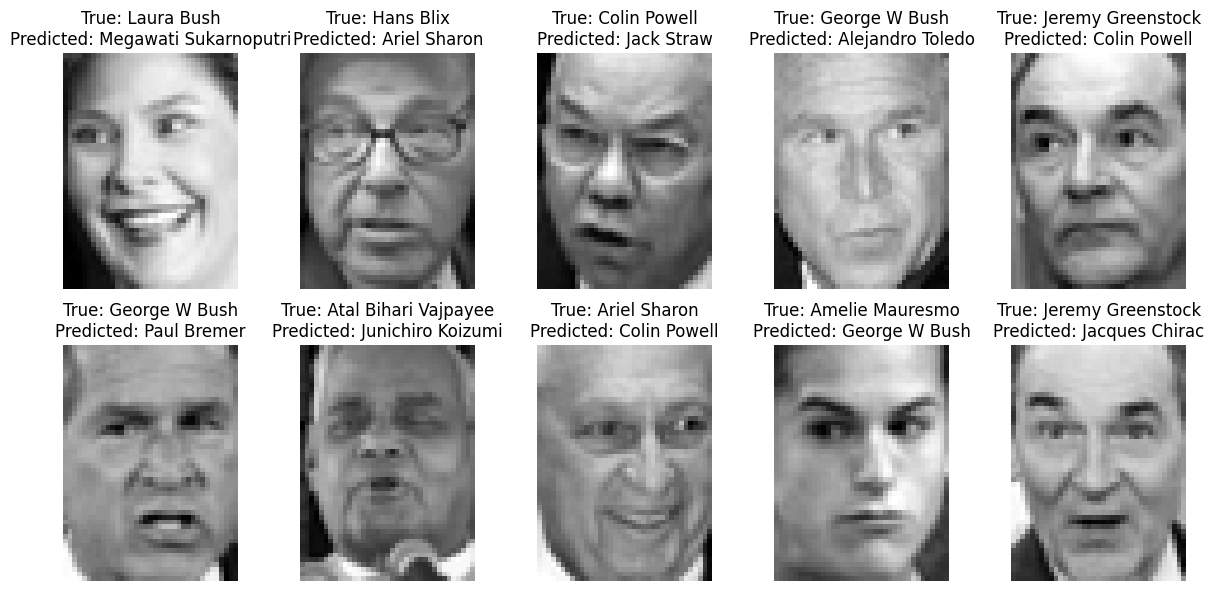

In [ ]:
show_misclassified_images(X_test, y_test, predictions_euclidean, target_names, num_images_to_show=10)

# Manhattan distance

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = None)

# Apply PCA
pca = PCA(n_components=150) # Param n_components : k - choosing apporpriately | whittening method
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Manhattan distances
predictions_manhattan = get_predictions(X_train_pca, y_train, X_test_pca, cityblock)

# Generate classification reports
report_manhattan = classification_report(y_test, predictions_manhattan)

print("Classification Report (Manhattan Distance):\n", report_manhattan)
print("Accuracy Score:")
print(accuracy_score(y_test, predictions_manhattan))

Classification Report (Manhattan Distance):
               precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.00      0.00      0.00         3
           2       1.00      0.67      0.80         3
           3       0.50      0.25      0.33         4
           4       0.50      0.50      0.50         2
           5       0.00      0.00      0.00         6
           6       0.50      0.33      0.40         6
           7       0.50      0.33      0.40         3
           8       0.67      0.40      0.50         5
           9       0.00      0.00      0.00         3
          10       0.66      0.69      0.68        36
          11       0.29      1.00      0.44         2
          12       0.44      0.53      0.48        15
          13       0.00      0.00      0.00         3
          14       0.53      0.67      0.59        45
          15       0.08      0.12      0.10         8
          16       0.86      0.75   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Total misclassified images: 169


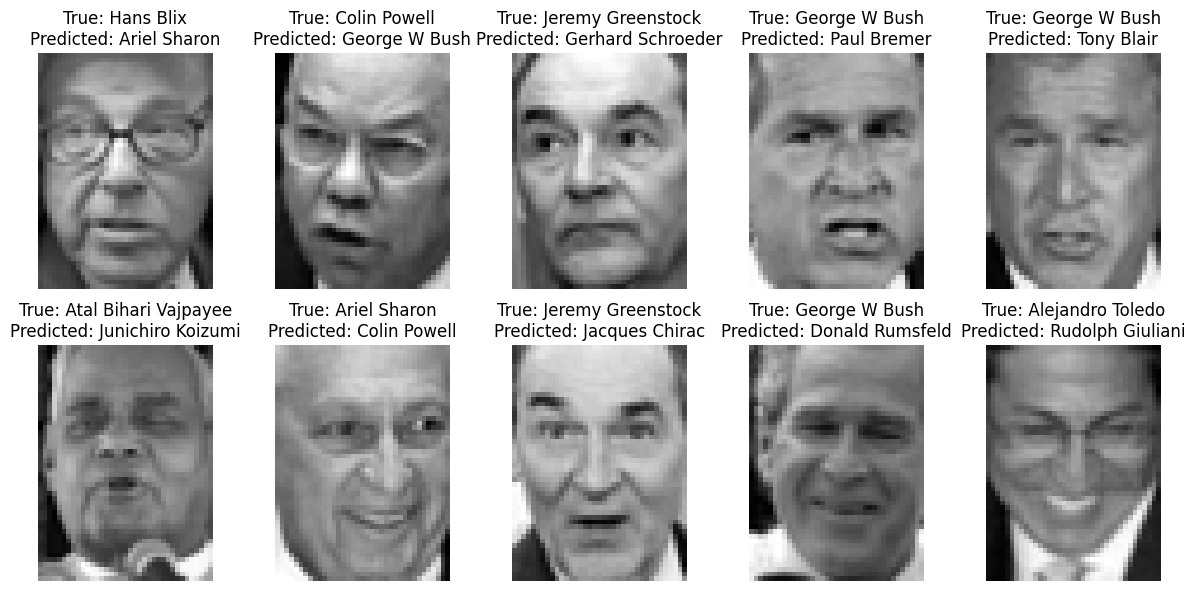

In [ ]:
show_misclassified_images(X_test, y_test, predictions_manhattan, target_names)

# Squared_euclidean

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = None)

# Apply PCA
pca = PCA(n_components=150) # Param n_components : k - choosing apporpriately | whittening method - No or
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#Square_euclidean
predictions_2_euclidean = get_predictions(X_train_pca, y_train, X_test_pca, squared_euclidean)

# Generate classification reports
report_2_euclidean = classification_report(y_test, predictions_2_euclidean)

print("Classification Report (squared_euclidean distance):\n", report_2_euclidean)
print("Accuracy Score:")
print(accuracy_score(y_test, predictions_2_euclidean))

Classification Report (squared_euclidean distance):
               precision    recall  f1-score   support

           0       0.33      0.38      0.35         8
           1       0.00      0.00      0.00         3
           2       0.50      0.33      0.40         3
           3       0.33      0.25      0.29         4
           4       0.25      0.50      0.33         2
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         6
           7       0.33      0.33      0.33         3
           8       0.50      0.20      0.29         5
           9       0.00      0.00      0.00         3
          10       0.61      0.53      0.57        36
          11       0.00      0.00      0.00         2
          12       0.38      0.40      0.39        15
          13       0.00      0.00      0.00         3
          14       0.36      0.47      0.40        45
          15       0.11      0.12      0.12         8
          16       1.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Total misclassified images: 201


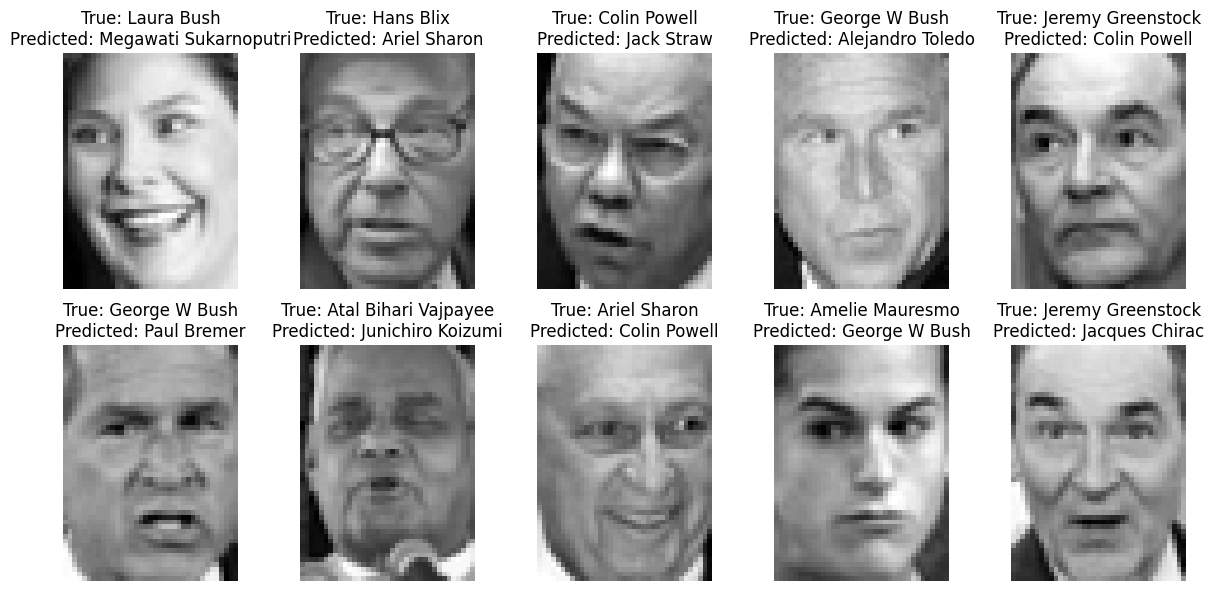

In [ ]:
show_misclassified_images(X_test, y_test, predictions_2_euclidean, target_names)

# Correlation Coeficent

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = None)

# Apply PCA
pca = PCA(n_components=150,whiten = True) # Param n_components : k - choosing apporpriately | whittening method - No or
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Correlation
predictions_corr = get_predictions(X_train_pca, y_train, X_test_pca, correlation_coefficient)

# Generate classification reports
report = classification_report(y_test, predictions_corr)

print("Classification Report (Correlation Coefficent):\n", report)
print("Accuracy Score:")
print(accuracy_score(y_test, predictions_corr))

Classification Report (Correlation Coefficent):
               precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.25      0.33      0.29         3
           2       1.00      0.67      0.80         3
           3       0.50      0.25      0.33         4
           4       0.25      0.50      0.33         2
           5       0.50      0.17      0.25         6
           6       0.00      0.00      0.00         6
           7       0.20      0.33      0.25         3
           8       1.00      0.20      0.33         5
           9       1.00      0.67      0.80         3
          10       0.79      0.92      0.85        36
          11       0.20      0.50      0.29         2
          12       0.50      0.53      0.52        15
          13       0.67      0.67      0.67         3
          14       0.55      0.76      0.64        45
          15       0.50      0.50      0.50         8
          16       1.00      0.6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Total misclassified images: 131


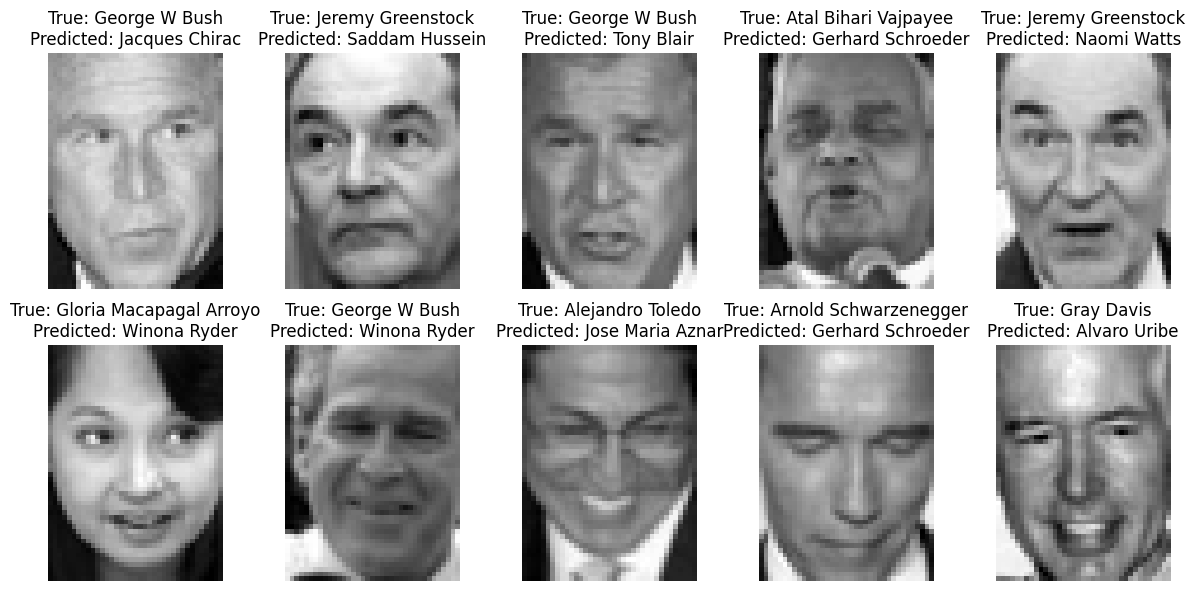

In [ ]:
show_misclassified_images(X_test, y_test, predictions_corr, target_names)

# Chi-squared distance

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = None)
# Apply PCA
pca = PCA(n_components=150, whiten = True) # Param n_components : k - choosing apporpriately | whittening method - No or
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
#Square_euclidean
predictions_chisq = get_predictions(X_train_pca, y_train, X_test_pca, chi_square_distance)

# Generate classification reports
report_chisq = classification_report(y_test, predictions_chisq)

print("Classification Report (chisquare distance):\n", report_chisq)
print("Accuracy Score:")
print(accuracy_score(y_test, predictions_chisq))

Classification Report (chisquare distance):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         3
          10       0.06      0.03      0.04        36
          11       0.00      0.00      0.00         2
          12       0.10      0.07      0.08        15
          13       0.00      0.00      0.00         3
          14       0.19      0.24      0.21        45
          15       0.00      0.00      0.00         8
          16       0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Total misclassified images: 288


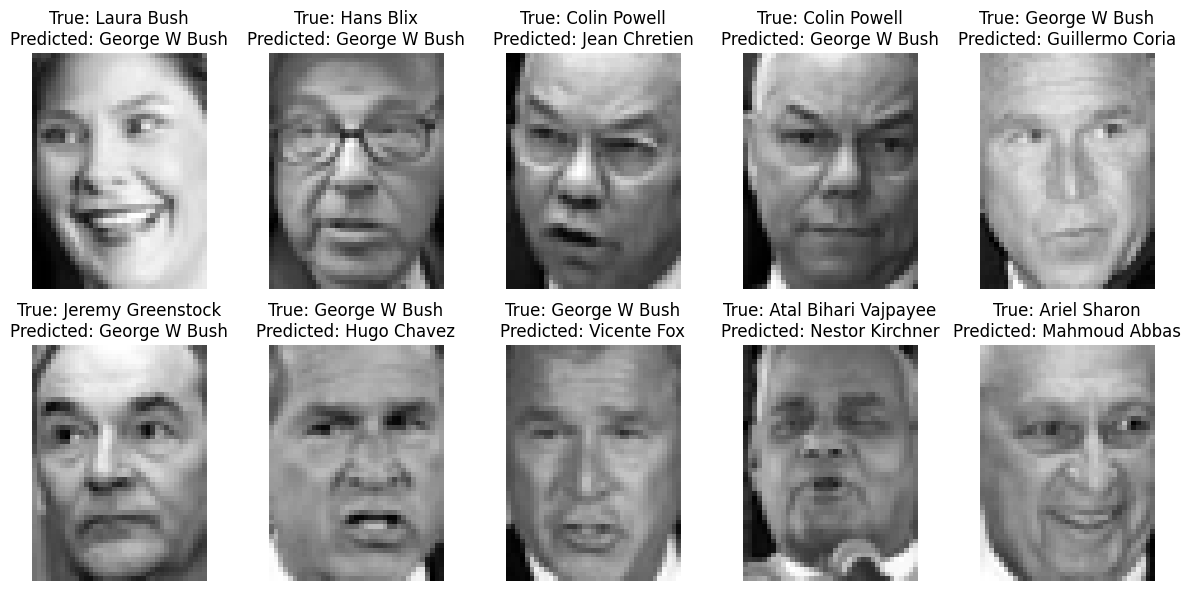

In [ ]:
show_misclassified_images(X_test, y_test, predictions_chisq, target_names)

# Canberra distance

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = None)

pca = PCA(n_components=150) # Param n_components : k - choosing apporpriately | whittening method - No or
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
#Square_euclidean
predictions_can = get_predictions(X_train_pca, y_train, X_test_pca, canberra_distance)

# Generate classification reports
report_can = classification_report(y_test, predictions_can)

print("Classification Report (squared_euclidean distance):\n", report_can)
print("Accuracy Score:")
print(accuracy_score(y_test, predictions_can))

Classification Report (squared_euclidean distance):
               precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.00      0.00      0.00         3
           2       0.40      0.67      0.50         3
           3       0.25      0.25      0.25         4
           4       0.00      0.00      0.00         2
           5       0.20      0.17      0.18         6
           6       0.33      0.17      0.22         6
           7       0.00      0.00      0.00         3
           8       0.67      0.40      0.50         5
           9       0.33      0.33      0.33         3
          10       0.68      0.75      0.71        36
          11       0.33      0.50      0.40         2
          12       0.60      0.40      0.48        15
          13       0.67      0.67      0.67         3
          14       0.60      0.67      0.63        45
          15       0.33      0.38      0.35         8
          16       0.71     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Total misclassified images: 164


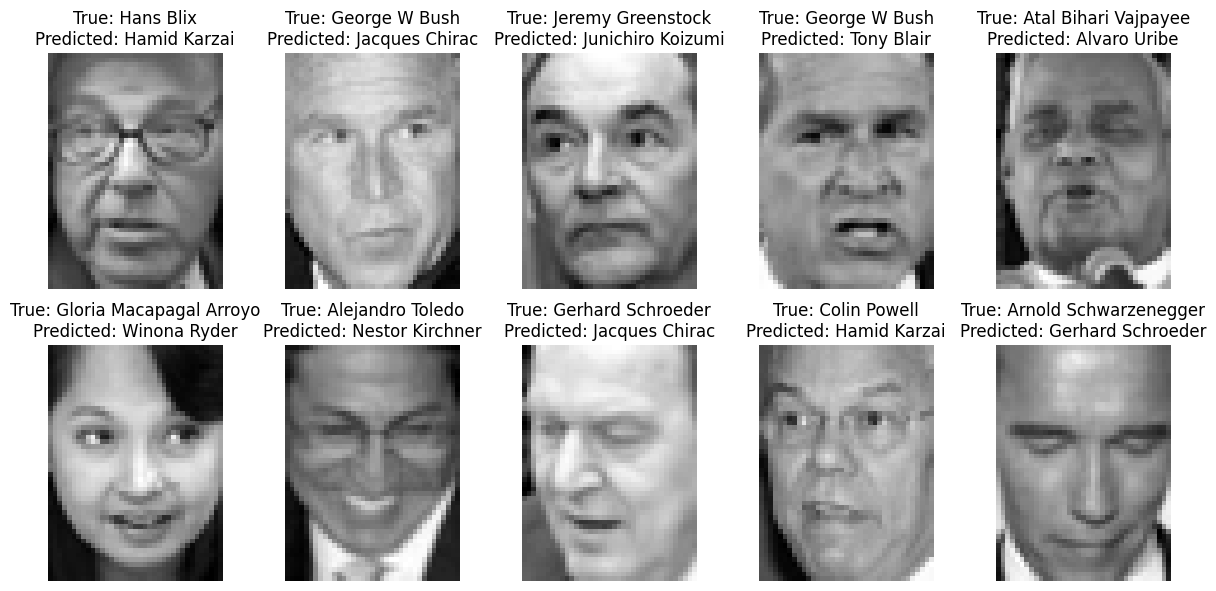

In [ ]:
show_misclassified_images(X_test, y_test, predictions_can, target_names)

# Cosine Similarity

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = None)

# Apply PCA
pca = PCA(n_components=150) # Param n_components : k - choosing apporpriately | whittening method - No or
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
#Square_euclidean
predictions_cos = get_predictions(X_train_pca, y_train, X_test_pca, cosine_distance)

# Generate classification reports
report_cos = classification_report(y_test, predictions_cos)

print("Classification Report (squared_euclidean distance):\n", report_cos)
print("Accuracy Score:")
print(accuracy_score(y_test, predictions_cos))

Classification Report (squared_euclidean distance):
               precision    recall  f1-score   support

           0       0.38      0.38      0.38         8
           1       0.00      0.00      0.00         3
           2       1.00      0.67      0.80         3
           3       0.17      0.25      0.20         4
           4       0.25      0.50      0.33         2
           5       0.20      0.17      0.18         6
           6       0.00      0.00      0.00         6
           7       0.50      0.33      0.40         3
           8       0.40      0.40      0.40         5
           9       0.00      0.00      0.00         3
          10       0.71      0.47      0.57        36
          11       0.00      0.00      0.00         2
          12       0.40      0.27      0.32        15
          13       0.00      0.00      0.00         3
          14       0.45      0.60      0.51        45
          15       0.08      0.12      0.10         8
          16       1.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Total misclassified images: 198


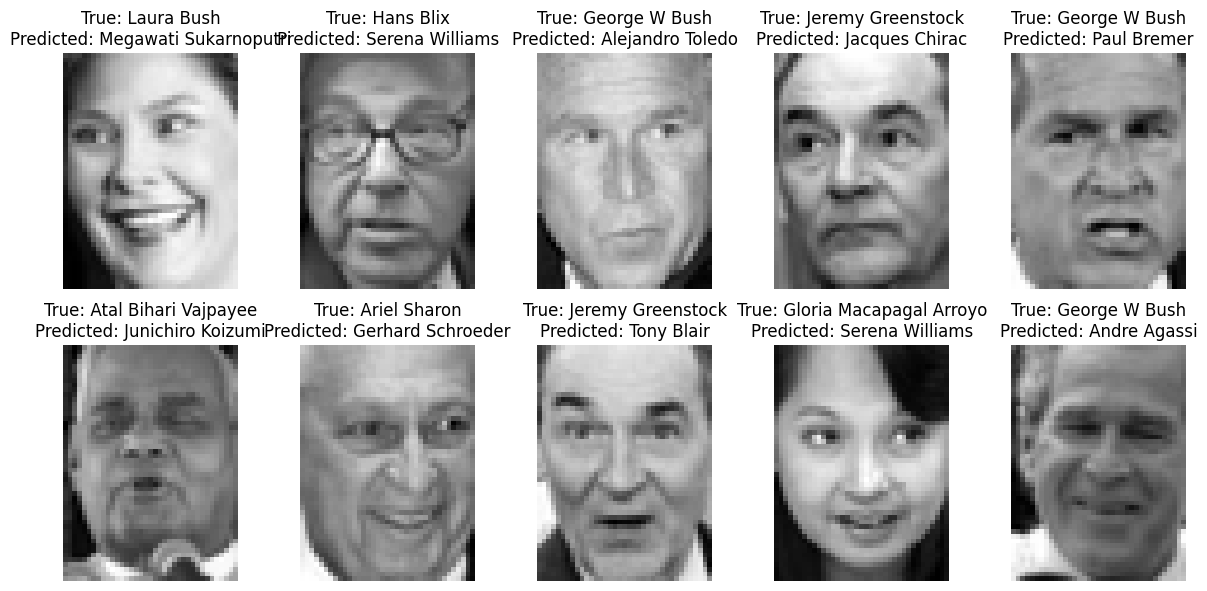

In [ ]:
show_misclassified_images(X_test, y_test, predictions_cos, target_names)

# Minkowski distance

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = None)

# Apply PCA
pca = PCA(n_components=150) # Param n_components : k - choosing apporpriately | whittening method - No or
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
#Square_euclidean
predictions_mink = get_predictions(X_train_pca, y_train, X_test_pca, minkowski_distance, 1) # p represent the norm of the distance based method

# Generate classification reports
report_mink = classification_report(y_test, predictions_mink)

print("Classification Report (Minkowski distance):\n", report_mink)
print("Accuracy Score:")
print(accuracy_score(y_test, predictions_mink))

Classification Report (Minkowski distance):
               precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.00      0.00      0.00         3
           2       1.00      0.67      0.80         3
           3       0.50      0.25      0.33         4
           4       0.50      0.50      0.50         2
           5       0.00      0.00      0.00         6
           6       0.50      0.33      0.40         6
           7       0.50      0.33      0.40         3
           8       0.25      0.20      0.22         5
           9       0.00      0.00      0.00         3
          10       0.71      0.69      0.70        36
          11       0.25      1.00      0.40         2
          12       0.50      0.53      0.52        15
          13       0.00      0.00      0.00         3
          14       0.55      0.67      0.60        45
          15       0.15      0.25      0.19         8
          16       0.88      0.88   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Total misclassified images: 168


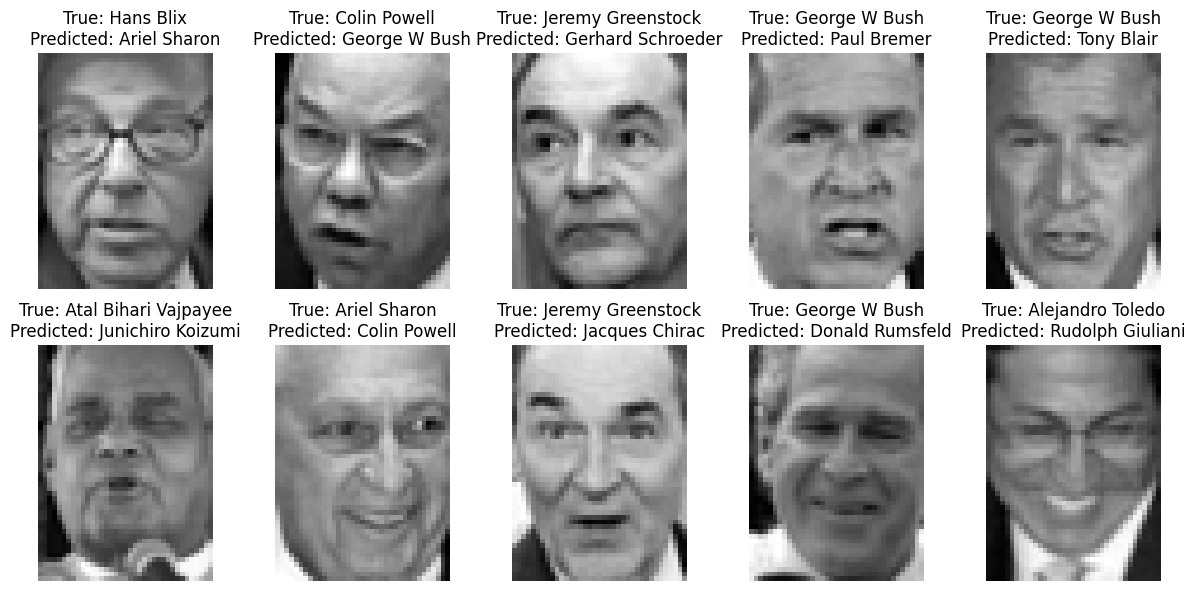

In [ ]:
show_misclassified_images(X_test, y_test, predictions_mink, target_names)

# Manhalanobis distance

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = None)

# Apply PCA
pca = PCA(n_components=150, whiten = True, svd_solver='randomized') # Param n_components : k - choosing apporpriately | whittening method - No or
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

cov_matrix = np.cov(X_train_pca.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)


def predict_label_mahalanobis(X_train_pca, y_train, test_sample_pca, inv_cov_matrix):
    distances = [mahalanobis_distance(train_sample_pca, test_sample_pca, inv_cov_matrix) for train_sample_pca in X_train_pca]
    min_index = np.argmin(distances)
    return y_train[min_index]

# Predict labels for each test sample
predictions_mahalanobis = [predict_label_mahalanobis(X_train_pca, y_train, test_sample_pca, inv_cov_matrix) for test_sample_pca in X_test_pca]

# Calculate accuracy score
accuracy_mahalanobis = accuracy_score(y_test, predictions_mahalanobis)
accuracy_mahalanobis

0.429042904290429

Total misclassified images: 173


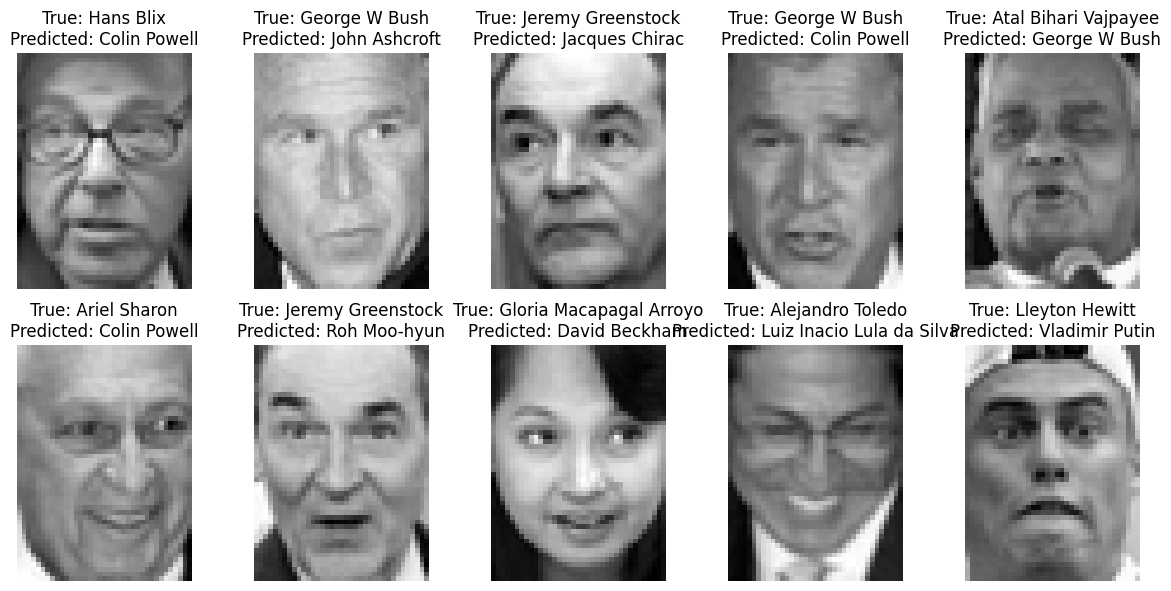

In [ ]:
show_misclassified_images(X_test, y_test, predictions_mahalanobis, target_names)

# summarize

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = None)

# Apply PCA
pca = PCA(n_components=150) # Param n_components : k - choosing apporpriately | whittening method - No or
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

def extract_overall_metrics(report, accuracy, metric_name):
    lines = report.split('\n')
    report_summary = lines[-2].split()
    return {
        "Distance Metric": metric_name,
        "Precision": report_summary[3],
        "Recall": report_summary[4],
        "F1-Score": report_summary[5],
        "Accuracy": accuracy
    }

def get_predictions_generic(X_train, y_train, X_test, distance_func, *args, **kwargs):
    predictions = []
    for test_sample in X_test:
        distances = [distance_func(test_sample, train_sample, *args, **kwargs) for train_sample in X_train]
        min_index = np.argmin(distances)
        predicted_label = y_train[min_index]
        predictions.append(predicted_label)
    return predictions

def evaluate_distance_method(distance_func, distance_name, *args, **kwargs):
    predictions = get_predictions_generic(X_train_pca, y_train, X_test_pca, distance_func, *args, **kwargs)
    report = classification_report(y_test, predictions, output_dict=True)
    accuracy = accuracy_score(y_test, predictions)
    return extract_overall_metrics(pd.DataFrame(report).transpose().to_string(), accuracy, distance_name)

minkowski_metrics = evaluate_distance_method(minkowski_distance, "Minkowski", p=3)

subset_methods = {
    "Euclidean": euclidean_distance,
    "Manhattan": manhattan_distance,
    "Cosine": cosine_distance,
    "Canberra": canberra_distance,
    "Squared Euclidean": squared_euclidean,
    "Correlation Coefficient": correlation_coefficient,
    "Chi Square": chi_square_distance
}

df_overall_scores = pd.DataFrame()
for method_name, method_func in subset_methods.items():
    metrics = evaluate_distance_method(method_func, method_name)
    df_overall_scores = pd.concat([df_overall_scores, pd.DataFrame([metrics])], ignore_index=True)


df_overall_scores = pd.concat([df_overall_scores, pd.DataFrame([minkowski_metrics])], ignore_index=True) ## Adding minkowski
df_overall_scores

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

,Distance Metric,Precision,Recall,F1-Score,Accuracy
0,Euclidean,0.249252,0.249011,303.000000,0.333333
1,Manhattan,0.299537,0.296763,303.000000,0.438944
2,Cosine,0.300827,0.275380,303.000000,0.349835
3,Canberra,0.329292,0.323676,303.000000,0.452145
4,Squared Euclidean,0.249252,0.249011,303.000000,0.333333
5,Correlation Coefficient,0.285580,0.255236,303.000000,0.333333
6,Chi Square,0.005510,0.006254,303.000000,0.033003
7,Minkowski,0.211329,0.199105,303.000000,0.290429


# Testing with stratify in split train test based on labels (which mean split the porpotion in each labels of the dataset)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)

# Apply PCA
pca = PCA(n_components=150) # Param n_components : k - choosing apporpriately | whittening method - No or
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

def extract_overall_metrics(report, accuracy, metric_name):
    lines = report.split('\n')
    report_summary = lines[-2].split()
    return {
        "Distance Metric": metric_name,
        "Precision": report_summary[3],
        "Recall": report_summary[4],
        "F1-Score": report_summary[5],
        "Accuracy": accuracy
    }

def get_predictions_generic(X_train, y_train, X_test, distance_func, *args, **kwargs):
    predictions = []
    for test_sample in X_test:
        distances = [distance_func(test_sample, train_sample, *args, **kwargs) for train_sample in X_train]
        min_index = np.argmin(distances)
        predicted_label = y_train[min_index]
        predictions.append(predicted_label)
    return predictions

def evaluate_distance_method(distance_func, distance_name, *args, **kwargs):
    predictions = get_predictions_generic(X_train_pca, y_train, X_test_pca, distance_func, *args, **kwargs)
    report = classification_report(y_test, predictions, output_dict=True)
    accuracy = accuracy_score(y_test, predictions)
    return extract_overall_metrics(pd.DataFrame(report).transpose().to_string(), accuracy, distance_name)

minkowski_metrics = evaluate_distance_method(minkowski_distance, "Minkowski", p=3)

subset_methods = {
    "Euclidean": euclidean_distance,
    "Manhattan": manhattan_distance,
    "Cosine": cosine_distance,
    "Canberra": canberra_distance,
    "Squared Euclidean": squared_euclidean,
    "Correlation Coefficient": correlation_coefficient,
    "Chi Square": chi_square_distance
}

df_overall_scores = pd.DataFrame()
for method_name, method_func in subset_methods.items():
    metrics = evaluate_distance_method(method_func, method_name)
    df_overall_scores = pd.concat([df_overall_scores, pd.DataFrame([metrics])], ignore_index=True)


df_overall_scores = pd.concat([df_overall_scores, pd.DataFrame([minkowski_metrics])], ignore_index=True) ## Adding minkowski
df_overall_scores

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

,Distance Metric,Precision,Recall,F1-Score,Accuracy
0,Euclidean,0.227632,0.233438,303.000000,0.333333
1,Manhattan,0.298144,0.300554,303.00000,0.402640
2,Cosine,0.230755,0.223957,303.000000,0.330033
3,Canberra,0.365011,0.357613,303.000000,0.475248
4,Squared Euclidean,0.227632,0.233438,303.000000,0.333333
5,Correlation Coefficient,0.228170,0.223078,303.000000,0.323432
6,Chi Square,0.009487,0.009318,303.000000,0.033003
7,Minkowski,0.175352,0.185544,303.000000,0.273927


# Testing with whitening method in PCA - reduce redundant in the dataset above

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)

# Apply PCA
pca = PCA(n_components=150, whiten = True) # Param n_components : k - choosing apporpriately | whittening method - No or
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

def extract_overall_metrics(report, accuracy, metric_name):
    lines = report.split('\n')
    report_summary = lines[-2].split()
    return {
        "Distance Metric": metric_name,
        "Precision": report_summary[3],
        "Recall": report_summary[4],
        "F1-Score": report_summary[5],
        "Accuracy": accuracy
    }

def get_predictions_generic(X_train, y_train, X_test, distance_func, *args, **kwargs):
    predictions = []
    for test_sample in X_test:
        distances = [distance_func(test_sample, train_sample, *args, **kwargs) for train_sample in X_train]
        min_index = np.argmin(distances)
        predicted_label = y_train[min_index]
        predictions.append(predicted_label)
    return predictions

def evaluate_distance_method(distance_func, distance_name, *args, **kwargs):
    predictions = get_predictions_generic(X_train_pca, y_train, X_test_pca, distance_func, *args, **kwargs)
    report = classification_report(y_test, predictions, output_dict=True)
    accuracy = accuracy_score(y_test, predictions)
    return extract_overall_metrics(pd.DataFrame(report).transpose().to_string(), accuracy, distance_name)

minkowski_metrics = evaluate_distance_method(minkowski_distance, "Minkowski", p=3)

subset_methods = {
    "Euclidean": euclidean_distance,
    "Manhattan": manhattan_distance,
    "Cosine": cosine_distance,
    "Canberra": canberra_distance,
    "Squared Euclidean": squared_euclidean,
    "Correlation Coefficient": correlation_coefficient,
    "Chi Square": chi_square_distance
}

df_overall_scores = pd.DataFrame()
for method_name, method_func in subset_methods.items():
    metrics = evaluate_distance_method(method_func, method_name)
    df_overall_scores = pd.concat([df_overall_scores, pd.DataFrame([metrics])], ignore_index=True)


df_overall_scores = pd.concat([df_overall_scores, pd.DataFrame([minkowski_metrics])], ignore_index=True) ## Adding minkowski
df_overall_scores

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

,Distance Metric,Precision,Recall,F1-Score,Accuracy
0,Euclidean,0.286972,0.292038,303.000000,0.425743
1,Manhattan,0.287297,0.293341,303.00000,0.402640
2,Cosine,0.436224,0.433575,303.000000,0.544554
3,Canberra,0.358152,0.358831,303.000000,0.458746
4,Squared Euclidean,0.286972,0.292038,303.000000,0.425743
5,Correlation Coefficient,0.433536,0.430931,303.000000,0.537954
6,Chi Square,0.018295,0.017858,303.000000,0.052805
7,Minkowski,0.278702,0.273430,303.000000,0.405941


# With weighted and estimated modifiers method

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)

# Apply PCA
pca = PCA(n_components=150) # Param n_components : k - choosing apporpriately | whittening method - No or
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

example_weights = np.ones(X_train_pca.shape[1])
example_modifier = 0.5

def extract_overall_metrics(report, accuracy, metric_name):
    lines = report.split('\n')
    report_summary = lines[-2].split()
    return {
        "Distance Metric": metric_name,
        "Precision": report_summary[3],
        "Recall": report_summary[4],
        "F1-Score": report_summary[5],
        "Accuracy": accuracy
    }

def evaluate_distance_method(distance_func, distance_name, *args, **kwargs):
    predictions = get_predictions_generic(X_train_pca, y_train, X_test_pca, distance_func, *args, **kwargs)
    report = classification_report(y_test, predictions, output_dict=True)
    accuracy = accuracy_score(y_test, predictions)
    return extract_overall_metrics(pd.DataFrame(report).transpose().to_string(), accuracy, distance_name)

# Initialize an empty DataFrame
df_overall_scores_2 = pd.DataFrame()

# Evaluate a subset of the distance methods
subset_methods = {
    "Weighted Manhattan": (weighted_manhattan, example_weights),
    "Weighted Squared Euclidean": (weighted_squared_euclidean, example_weights),
    "Weighted Angle-Based": (weighted_angle_based_distance, example_weights),
    "Modified SSE-Based": (modified_sse_based_distance, example_weights),
    "Modified Manhattan": (modified_manhattan, example_modifier),
    "Modified Squared Euclidean": (modified_squared_euclidean, example_modifier),
    "Weighted Modified Manhattan": (weighted_modified_manhattan, example_weights, example_modifier),
    "Weighted Modified Squared Euclidean": (weighted_modified_squared_euclidean, example_weights, example_modifier)
}

# Evaluate the model using different distance metrics
df_overall_scores_2 = pd.DataFrame()

for method_name, method_args in subset_methods.items():
    metrics = evaluate_distance_method(method_args[0], method_name, *method_args[1:])
    df_overall_scores_2 = pd.concat([df_overall_scores_2, pd.DataFrame([metrics])], ignore_index=True)

df_overall_scores_2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

,Distance Metric,Precision,Recall,F1-Score,Accuracy
0,Weighted Manhattan,0.293744,0.295820,303.000000,0.405941
1,Weighted Squared Euclidean,0.229478,0.237192,303.000000,0.330033
2,Weighted Angle-Based,0.234286,0.227591,303.000000,0.336634
3,Modified SSE-Based,0.229478,0.237192,303.000000,0.330033
4,Modified Manhattan,0.142347,0.144441,303.000000,0.257426
5,Modified Squared Euclidean,0.209649,0.200678,303.000000,0.290429
6,Weighted Modified Manhattan,0.142347,0.144441,303.000000,0.257426
7,Weighted Modified Squared Euclidean,0.209649,0.200678,303.000000,0.290429


# With stratify

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)

# Apply PCA
pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

example_weights = np.ones(X_train_pca.shape[1])
example_modifier = 0.5# Compute the inverse of the covariance matrix

def extract_overall_metrics(report, accuracy, metric_name):
    lines = report.split('\n')
    report_summary = lines[-2].split()
    return {
        "Distance Metric": metric_name,
        "Precision": report_summary[3],
        "Recall": report_summary[4],
        "F1-Score": report_summary[5],
        "Accuracy": accuracy
    }

def evaluate_distance_method(distance_func, distance_name, *args, **kwargs):
    predictions = get_predictions_generic(X_train_pca, y_train, X_test_pca, distance_func, *args, **kwargs)
    report = classification_report(y_test, predictions, output_dict=True)
    accuracy = accuracy_score(y_test, predictions)
    return extract_overall_metrics(pd.DataFrame(report).transpose().to_string(), accuracy, distance_name)

# Initialize an empty DataFrame
df_overall_scores_2 = pd.DataFrame()

# Evaluate a subset of the distance methods
subset_methods = {
    "Weighted Manhattan": (weighted_manhattan, example_weights),
    "Weighted Squared Euclidean": (weighted_squared_euclidean, example_weights),
    "Weighted Angle-Based": (weighted_angle_based_distance, example_weights),
    "Modified SSE-Based": (modified_sse_based_distance, example_weights),
    "Modified Manhattan": (modified_manhattan, example_modifier),
    "Modified Squared Euclidean": (modified_squared_euclidean, example_modifier),
    "Weighted Modified Manhattan": (weighted_modified_manhattan, example_weights, example_modifier),
    "Weighted Modified Squared Euclidean": (weighted_modified_squared_euclidean, example_weights, example_modifier)
}

# Evaluate the model using different distance metrics
df_overall_scores_2 = pd.DataFrame()

for method_name, method_args in subset_methods.items():
    metrics = evaluate_distance_method(method_args[0], method_name, *method_args[1:])
    df_overall_scores_2 = pd.concat([df_overall_scores_2, pd.DataFrame([metrics])], ignore_index=True)

df_overall_scores_2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

,Distance Metric,Precision,Recall,F1-Score,Accuracy
0,Weighted Manhattan,0.303959,0.305039,303.000000,0.415842
1,Weighted Squared Euclidean,0.219263,0.222313,303.000000,0.326733
2,Weighted Angle-Based,0.233614,0.229517,303.000000,0.333333
3,Modified SSE-Based,0.219263,0.222313,303.000000,0.326733
4,Modified Manhattan,0.146909,0.142035,303.000000,0.250825
5,Modified Squared Euclidean,0.222319,0.213060,303.000000,0.306931
6,Weighted Modified Manhattan,0.146909,0.142035,303.000000,0.250825
7,Weighted Modified Squared Euclidean,0.222319,0.213060,303.000000,0.306931


# With whitening method

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Apply PCA
pca = PCA(n_components=150, whiten = True) # Param n_components : k - choosing apporpriately | whittening method - No or
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

example_weights = np.ones(X_train_pca.shape[1])
example_modifier = 0.5# Compute the inverse of the covariance matrix

def extract_overall_metrics(report, accuracy, metric_name):
    lines = report.split('\n')
    report_summary = lines[-2].split()
    return {
        "Distance Metric": metric_name,
        "Precision": report_summary[3],
        "Recall": report_summary[4],
        "F1-Score": report_summary[5],
        "Accuracy": accuracy
    }

def evaluate_distance_method(distance_func, distance_name, *args, **kwargs):
    predictions = get_predictions_generic(X_train_pca, y_train, X_test_pca, distance_func, *args, **kwargs)
    report = classification_report(y_test, predictions, output_dict=True)
    accuracy = accuracy_score(y_test, predictions)
    return extract_overall_metrics(pd.DataFrame(report).transpose().to_string(), accuracy, distance_name)

# Initialize an empty DataFrame
df_overall_scores_2 = pd.DataFrame()

# Evaluate a subset of the distance methods
subset_methods = {
    "Weighted Manhattan": (weighted_manhattan, example_weights),
    "Weighted Squared Euclidean": (weighted_squared_euclidean, example_weights),
    "Weighted Angle-Based": (weighted_angle_based_distance, example_weights),
    "Modified SSE-Based": (modified_sse_based_distance, example_weights),
    "Modified Manhattan": (modified_manhattan, example_modifier),
    "Modified Squared Euclidean": (modified_squared_euclidean, example_modifier),
    "Weighted Modified Manhattan": (weighted_modified_manhattan, example_weights, example_modifier),
    "Weighted Modified Squared Euclidean": (weighted_modified_squared_euclidean, example_weights, example_modifier)
}

# Evaluate the model using different distance metrics
df_overall_scores_2 = pd.DataFrame()

for method_name, method_args in subset_methods.items():
    metrics = evaluate_distance_method(method_args[0], method_name, *method_args[1:])
    df_overall_scores_2 = pd.concat([df_overall_scores_2, pd.DataFrame([metrics])], ignore_index=True)

df_overall_scores_2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

,Distance Metric,Precision,Recall,F1-Score,Accuracy
0,Weighted Manhattan,0.309712,0.298120,303.000000,0.455446
1,Weighted Squared Euclidean,0.293638,0.300241,303.000000,0.438944
2,Weighted Angle-Based,0.467335,0.450490,303.000000,0.567657
3,Modified SSE-Based,0.293638,0.300241,303.000000,0.438944
4,Modified Manhattan,0.281257,0.284451,303.000000,0.382838
5,Modified Squared Euclidean,0.292447,0.292417,303.000000,0.405941
6,Weighted Modified Manhattan,0.281257,0.284451,303.000000,0.382838
7,Weighted Modified Squared Euclidean,0.292447,0.292417,303.000000,0.405941
